In [1]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from XVA import *
from XVAFBSNNs import *

In [3]:
from FBSNNs import *
from ForwardContracts import *

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 64  # number of trajectories (batch size)
N = 100  # number of time snapshots
D = 1 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 2 * [21] + [1]

Xi = np.array([1] * int(D))[None, :]
T = 1.0

"Available architectures"
mode = "NAIS-Net"  # FC, Resnet and NAIS-Net are available
activation = "Sine"  # Sine and ReLU are available
model = ForwardContracts(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2 * 10**4
lr = 1e-3

In [5]:
model.load_model("models/Forward1D2.pth")

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 64  # number of trajectories (batch size)
N = 100  # number of time snapshots
D = 1 # number of dimensions
Mm = N ** (1/5)

layers = [1+1] + 2 * [21] + [1]

Xi = np.array([1] * int(D))[None, :]
T = 1.0

"Available architectures"
mode = "NAIS-Net"  # FC, Resnet and NAIS-Net are available
activation = "Sine"  # Sine and ReLU are available
xvamodel = XVA(Xi, T, M, N, D, Mm, layers, mode, activation, model)

n_iter = 2 * 10**3
lr = 1e-3

In [7]:
xvamodel.load_model("models/1DForwardFVAXVAPaper.pth")

In [8]:
t_test, W_test, C_test = xvamodel.fetch_minibatch()
X_pred, Y_pred = xvamodel.predict(C_test, t_test, W_test)
if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

for i in range(63):
    t_test_i, W_test_i, C_test_i = xvamodel.fetch_minibatch()
    X_pred_i, Y_pred_i = xvamodel.predict(C_test_i, t_test_i, W_test_i)
    if type(t_test_i).__module__ != 'numpy':
        t_test_i = t_test_i.cpu().numpy()
    if type(X_pred_i).__module__ != 'numpy':
        X_pred_i = X_pred_i.cpu().detach().numpy()
    if type(Y_pred_i).__module__ != 'numpy':
        Y_pred_i = Y_pred_i.cpu().detach().numpy()
    t_test = np.concatenate((t_test, t_test_i), axis=0)
    X_pred = np.concatenate((X_pred, X_pred_i), axis=0)
    Y_pred = np.concatenate((Y_pred, Y_pred_i), axis=0)


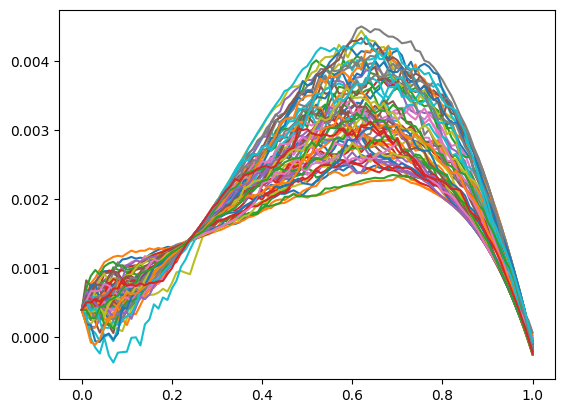

In [9]:
plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, label='Learned $u(t,X_t)$')
plt.plot(t_test[1:64, :, 0].T, Y_pred[1:64, :, 0].T)
plt.show()

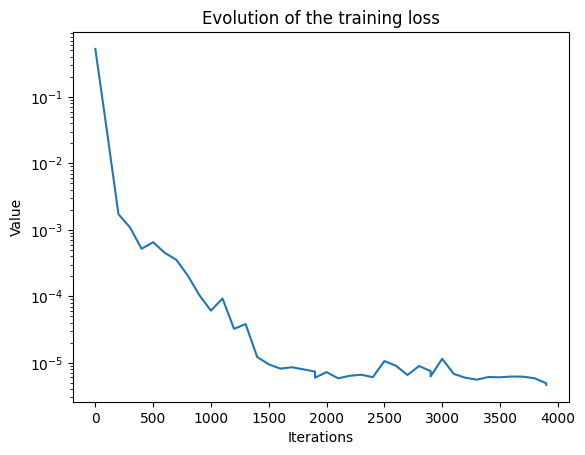

In [10]:
graph = xvamodel.iteration, xvamodel.training_loss
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')
plt.show()

In [11]:
Y_pred.shape

(64, 101, 1)

In [12]:
Y_preds = Y_pred.reshape(64, 101)

In [23]:
pred_fva = Y_preds[:,0][0] * 100

In [24]:
pred_fva

0.03913417458534241

In [25]:
time_stamp = t_test[0].reshape(101,)
time_stamp

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ], dtype=float32)

In [26]:
x_init = 100
strike = 100
r = 0.02
sigma = 0.25
total_time = 1
r_f = 0.04

In [27]:
from scipy.stats import norm

rv = norm()    

d1 = np.array([(-r * s + np.log(x_init/strike) + (r+sigma**2/2)*s)/sigma/np.sqrt(s) 
            for s in time_stamp[1:]])
d2 = np.array([d1[i]-sigma*np.sqrt(s) for i,s in enumerate(time_stamp[1:])])

epe_exact = x_init*rv.cdf(d1) - strike*np.exp(-r)*rv.cdf(d2)
ene_exact = x_init*rv.cdf(-d1) - strike*np.exp(-r)*rv.cdf(-d2)

In [28]:
exactYhat = x_init - strike*np.exp(-r * total_time)
exactY = np.exp(-(r_f - r) * total_time)*x_init - strike*np.exp(-r_f * total_time)
exact_fva = exactYhat - exactY

In [29]:
exact_fva

0.039209253881267614

In [30]:
(pred_fva - exact_fva) ** 2 / exact_fva ** 2

3.666597401140731e-06

In [31]:
np.abs(pred_fva - exact_fva)

7.507929592520668e-05

In [28]:
xvamodel.save_model("models/1DForwardFVAXVAPaper.pth")